# Predicting missing values of Work Rate column using RandomForestRegressor

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

df = pd.read_csv("fifa22_cleaned.csv")
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16710 entries, 0 to 16709
Data columns (total 54 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ID                        16710 non-null  int64  
 1   Name                      16710 non-null  object 
 2   Age                       16710 non-null  int64  
 3   Nationality               16710 non-null  object 
 4   Overall                   16710 non-null  int64  
 5   Potential                 16710 non-null  int64  
 6   Club                      16446 non-null  object 
 7   Value                     16710 non-null  float64
 8   Wage                      16710 non-null  float64
 9   Special                   16710 non-null  int64  
 10  Preferred Foot            16710 non-null  object 
 11  International Reputation  16710 non-null  float64
 12  Weak Foot                 16710 non-null  float64
 13  Skill Moves               16710 non-null  float64
 14  Work R

## Checking co-relation between features
### Work Rate is random so, will be difficult to predict values
### higher the value of co-relation , more the features are dependent

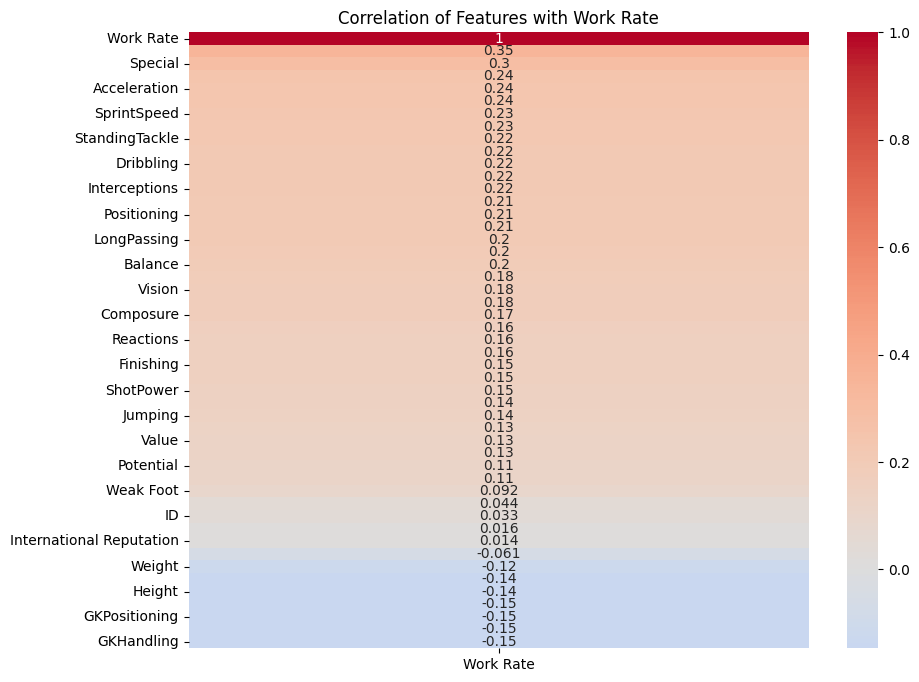

In [2]:
# Select only numeric columns (so correlation makes sense)
numeric_df = df.select_dtypes(include=["int64", "float64"])

# Drop rows where Work Rate is missing
numeric_df = numeric_df.dropna(subset=["Work Rate"])

# Compute correlation matrix
corr = numeric_df.corr()

# Focus on Work Rate correlations
plt.figure(figsize=(10,8))
sns.heatmap(corr[["Work Rate"]].sort_values(by="Work Rate", ascending=False),
            annot=True, cmap="coolwarm", center=0)
plt.title("Correlation of Features with Work Rate")
plt.show()

## We are using the following features to try and predict the values of work rate

In [3]:
# --- Features and target ---
features = [
    "Overall", "Age", "Acceleration", "SprintSpeed", "StandingTackle",
    "DefensiveAwareness", "Interceptions", "Positioning", "LongPassing",
    "Balance", "Vision", "Composure", "Reactions", "Finishing",
    "ShotPower", "Jumping", "HeadingAccuracy", "Potential", "Special"
]
target = "Work Rate"

# --- Drop rows with missing values in features or target ---
train_data = df.dropna(subset=features + [target])
X = train_data[features]
y = train_data[target]

print(X.info())
print(y.info())

<class 'pandas.core.frame.DataFrame'>
Index: 15818 entries, 0 to 16708
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Overall             15818 non-null  int64  
 1   Age                 15818 non-null  int64  
 2   Acceleration        15818 non-null  float64
 3   SprintSpeed         15818 non-null  float64
 4   StandingTackle      15818 non-null  float64
 5   DefensiveAwareness  15818 non-null  float64
 6   Interceptions       15818 non-null  float64
 7   Positioning         15818 non-null  float64
 8   LongPassing         15818 non-null  float64
 9   Balance             15818 non-null  float64
 10  Vision              15818 non-null  float64
 11  Composure           15818 non-null  float64
 12  Reactions           15818 non-null  float64
 13  Finishing           15818 non-null  float64
 14  ShotPower           15818 non-null  float64
 15  Jumping             15818 non-null  float64
 16  HeadingAc

In [4]:
# --- Train/test split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Train model ---
model = RandomForestRegressor(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

# --- Evaluate model ---
y_pred = model.predict(X_test)

print(y_pred)

[7.1015 8.0855 7.3025 ... 7.1905 8.1735 6.7025]


### R-squared is very low (near to 1 is considered good) , since work rate is random and doesn't depends on any features
### Mean Asolute Error and Root Mean Square Error should me closer to 0 for better predictions

In [5]:
print("R²:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", rmse)

R²: 0.14342876542408212
MAE: 0.8381572376738335
RMSE: 1.1028602832818768


### Trying bias towards average value also doesn't imporve the model

In [6]:
# --- Bias correction: shrink predictions toward global mean ---
global_mean = y.mean()
alpha = 0.1  # shrinkage factor, 0 = no correction, 1 = always mean
y_pred_bias = (1 - alpha) * y_pred + alpha * global_mean

print("\nWith bias correction:")
print("R²:", r2_score(y_test, y_pred_bias))
print("MAE:", mean_absolute_error(y_test, y_pred_bias))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_bias)))


With bias correction:
R²: 0.14588749818830893
MAE: 0.847094384877587
RMSE: 1.1012763009477924


### checking model accuracy (quite bad)

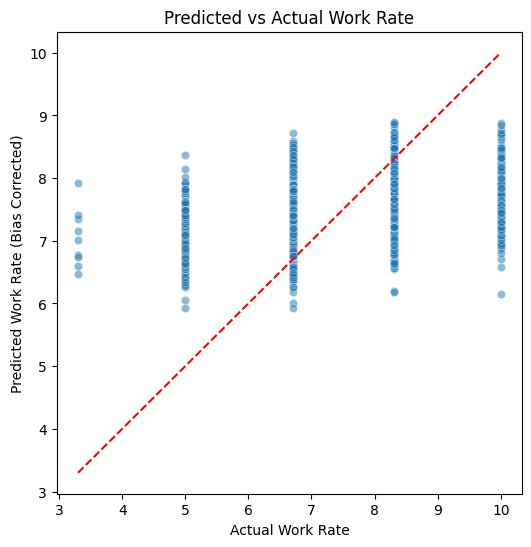

In [7]:
# --- Plot Predicted vs Actual (with bias) ---
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred_bias, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Work Rate")
plt.ylabel("Predicted Work Rate (Bias Corrected)")
plt.title("Predicted vs Actual Work Rate")
plt.show()

C:\Users\shiva\AppData\Local\Temp\ipykernel_21864\2243870158.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices], y=np.array(features)[indices], palette="viridis")


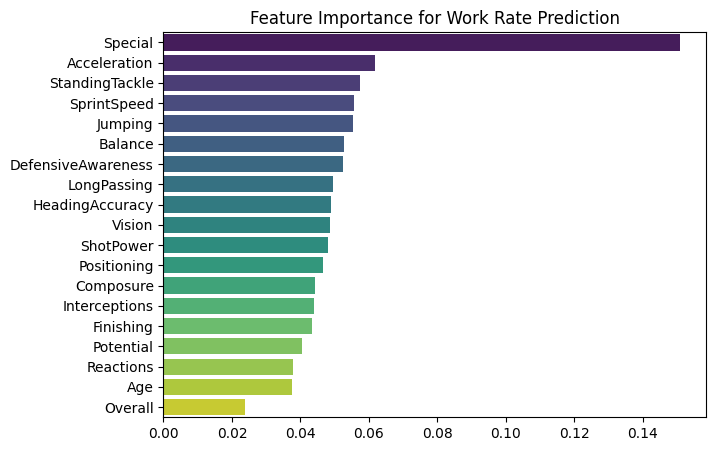

In [8]:
# --- Feature Importance ---
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(7,5))
sns.barplot(x=importances[indices], y=np.array(features)[indices], palette="viridis")
plt.title("Feature Importance for Work Rate Prediction")
plt.show()

## Predicting the null values of work rate and saving the dataset, to be used in third notebook in same repo for predicting missing stats

In [9]:
# --- Predict missing Work Rate values ---
missing_mask = df[target].isna()
X_missing = df.loc[missing_mask, features]

if X_missing.shape[0] > 0:
    predicted_work_rate = model.predict(X_missing)
    # Apply same bias correction
    predicted_work_rate = (1 - alpha) * predicted_work_rate + alpha * global_mean
    df.loc[missing_mask, target] = predicted_work_rate
    print(f"Filled {X_missing.shape[0]} missing Work Rate values.")
else:
    print("No missing Work Rate values found.")

print("\nFinal info:")
print(df.info())

Filled 51 missing Work Rate values.

Final info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16710 entries, 0 to 16709
Data columns (total 54 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ID                        16710 non-null  int64  
 1   Name                      16710 non-null  object 
 2   Age                       16710 non-null  int64  
 3   Nationality               16710 non-null  object 
 4   Overall                   16710 non-null  int64  
 5   Potential                 16710 non-null  int64  
 6   Club                      16446 non-null  object 
 7   Value                     16710 non-null  float64
 8   Wage                      16710 non-null  float64
 9   Special                   16710 non-null  int64  
 10  Preferred Foot            16710 non-null  object 
 11  International Reputation  16710 non-null  float64
 12  Weak Foot                 16710 non-null  float64
 13  Skill Moves 

In [10]:
df.to_csv("fifa22_cleaned_with_workrate.csv", index=False)